# ** Описание **

$$P(AB)=P(A|B)P(B)=P(B|A)P(A)$$
$$P(A|B)=\frac{P(B|A)P(A)}{P(B)}$$
$$P(C|D)=\frac{P(D|C)P(C)}{P(D)}=\frac{P(x_1..x_n|C)P(C)}{P(D)}$$
Наивность заключается в том, что мы считаем все слова(признаки) независимыми между собой
$$P(x_1..x_n|C)=\prod_{i}^{n}P(x_i|C)$$

Соответственно тогда, вероятности того, что документ принадлежит каждому классу можно записат следующим образом

$$P(C|D)=\frac{\prod_{i}^{n}P(x_i|C)P(C)}{P(D)}$$
$$P(\neg C|D)=\frac{\prod_{i}^{n}P(x_i|\neg C)P(\neg C)}{P(D)}$$

Если поделить две эти вероятности, то мы сократим общие члены и упростим формулу

$$\frac{P(C|D)}{P(\neg C|D)}=\frac{\prod_{i}^{n}P(x_i|C)P(C)}{\prod_{i}^{n}P(x_i|\neg C)P(\neg C)}$$
$$ln\frac{P(C|D)}{P(\neg C|D)}=ln\frac{P(C)}{P(\neg C)}+\sum_{i}^{n}ln\frac{P(x_i|C)}{P(x_i|\neg C)}=$$
$$ln\frac{P(C)}{P(\neg C)}+\sum_{i}^{n}ln\frac{classCfreqX_i}{classNotCfreqX_i}$$
$$P(x_i|C)=classCfreqX_i/total$$
$$P(x_i|\neg C)=classNotCfreqX_i/total$$
$$ln\frac{P(C)}{P(\neg C)} = const$$
$$P(C|D) + P(\neg C|D) = 1$$

In [1]:
import base64
import csv
import gzip
import zlib
import random

from collections import namedtuple
from collections import Counter

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
TRACE_NUM = 500
from importlib import reload
import logging
reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%H:%M:%S')

def trace(items_num, trace_num=TRACE_NUM):
    if items_num % trace_num == 0: logging.info("Complete items %05d" % items_num)

### Утилиты

#### Декораторы

In [3]:
def to_utf8(text):
    if isinstance(text, str): text = text.encode('utf8')
    return text

def convert2unicode(f):
    def tmp(text):
        if not isinstance(text, str): text = text.decode('utf8')
        return f(text)
    return tmp

def convert2lower(f):
    def tmp(text):        
        return f(text.lower())
    return tmp

#P.S. Декораторы могут усложнять отладку, так что от них вполне можно отказаться и воспользоваться copy-paste

### Извлечение текста из html

#### Извлечение текста при помощи встроенных модулей

In [4]:
from html.parser import HTMLParser
import re

###Извлечение текста из title можно вписать сюда

class TextHTMLParser(HTMLParser):
    def __init__(self):
        HTMLParser.__init__(self)
        self._text = []
        self._title = ""
        self._in_title = False

    def handle_data(self, data):
        text = data.strip()
        if len(text) > 0:
            text = re.sub('[ \t\r\n]+', ' ', text)
            self._text.append(text + ' ')

    def handle_starttag(self, tag, attrs):
        if tag == 'p':
            self._text.append('\n\n')
        elif tag == 'br':
            self._text.append('\n')
        elif tag == 'title':
            self._in_title = True

    def handle_startendtag(self, tag, attrs):
        if tag == 'br':
            self._text.append('\n\n')

    def text(self):
        return ''.join(self._text).strip()

@convert2unicode
def html2text_parser(text):
    parser = TextHTMLParser()
    parser.feed(text)
    return parser.text()

#### Извлечение текста при помощи дополнительных библиотек

In [5]:
def html2text_bs(raw_html):
    from bs4 import BeautifulSoup
    """
    Тут производится извлечения из html текста
    """
    soup = BeautifulSoup(raw_html, "html.parser")
    [s.extract() for s in soup(['script', 'style'])]
    return soup.get_text()

def html2text_bs_visible(raw_html):
    from bs4 import BeautifulSoup
    """
    Тут производится извлечения из html текста, который видим пользователю
    """
    soup = BeautifulSoup(raw_html, "html.parser")    
    [s.extract() for s in soup(['style', 'script', '[document]', 'head', 'title'])]
    return soup.get_text()

def html2text_boilerpipe(raw_html):
    import boilerpipe
    """
    еще одна библиотека очень хорошо извлекающая именно видимый пользователю текст,
    но она завязана на java
    """
    pass

#### Выбираем какой метод для конвертации html в текст будет основным

In [6]:
html2text = html2text_bs
#html2text = html2text_parser

#### Методы для токенизации текста

In [7]:
@convert2lower
@convert2unicode
def easy_tokenizer(text):
    word = str()
    for symbol in text:
        if symbol.isalnum(): word += symbol
        elif word:
            yield word
            word = str()
    if word: yield word

PYMORPHY_CACHE = {}
MORPH = None
#hint, чтобы установка pymorphy2 не была бы обязательной
def get_lemmatizer():
    import pymorphy2
    global MORPH
    if MORPH is None: MORPH = pymorphy2.MorphAnalyzer()
    return MORPH

@convert2lower
@convert2unicode
def pymorphy_tokenizer(text):
    global PYMORPHY_CACHE
    for word in easy_tokenizer(text):
        word_hash = hash(word)
        if word_hash not in PYMORPHY_CACHE:
            PYMORPHY_CACHE[word_hash] = get_lemmatizer().parse(word)[0].normal_form            
        yield PYMORPHY_CACHE[word_hash]

#### Основная функция, которая вызывается для преобразования html в список слов

In [8]:
def html2word(raw_html, to_text=html2text, tokenizer=easy_tokenizer):
    return tokenizer(to_text(raw_html).lower())

#### Рассчет финальных метрик

In [9]:
def safe_divide(a, b):
    if a == 0: return 0.0
    elif b == 0: return 0.0
    else: return a/b

def calculate_metrics(predictions, threshold):    
    """
    Функция подсчета метрик
    Параметры
    predictions - ранки по документам
    threshold  - порог для метрик
    """
    true_positive = 0
    false_positive = 0
    true_negative = 0
    false_negative = 0
    for (url_id, mark, url, prediction) in predictions:        
        mark_predict = prediction > threshold

        if mark_predict:                     
            if mark_predict == mark: true_positive += 1
            else: false_positive += 1                    
        else:                     
            if  mark_predict == mark: true_negative += 1
            else: false_negative += 1

    class_prec  = safe_divide(true_positive, true_positive + false_positive)
    class_recall = safe_divide(true_positive, true_positive + false_negative)
        
    class_F1 = safe_divide(2 * class_prec * class_recall, class_prec + class_recall)
    
    
    not_class_prec = safe_divide(true_negative, true_negative + false_negative)
    not_class_recall = safe_divide(true_negative, true_negative + false_positive)
    
    not_class_F1 = safe_divide(2 * not_class_prec * not_class_recall, not_class_prec + not_class_recall)
    
    return ( (class_prec, class_recall, class_F1), (not_class_prec, not_class_recall, not_class_F1) )

def arange(start, stop, step):
    cur_value = start
    while True:
        if cur_value > stop: break
        yield cur_value
        cur_value += step

def plot_results(docs, min_threshold=-1, max_threshold=1, step=0.1, trace=False, plot=False):
    x = []
    y_p = []
    y_n = []
    avgF1 = []
    docs_predictions = classifier.predict_all(docs)
    for threshold in arange(min_threshold, max_threshold, step):
        r = calculate_metrics(docs_predictions, threshold)
        x.append(threshold)
        y_p.append(r[0])
        y_n.append(r[1])
        avgF1.append((r[0][2] + r[1][2]) / 2.0)
        if trace: 
            print('threshold %s' % threshold)
            print('\tclass_prec %s, class_recall %s, class_F1 %s' % r[0])
            print('\tnot_class_prec %s, not_class_recall %s, not_class_F1 %s' % r[1])
            print('\t\tMacroF1Mesure %s' % ((r[0][2] + r[1][2])/2))
    if plot:
        plot_stats(x, y_p, "Class Result")
        plot_stats(x, y_n, "Not class Result")
    
    return avgF1


def plot_stats(x, y, title):
    plt.figure(figsize=(10, 5))

    prec, = plt.plot( x, 
                     [k[0] for k in y], "r", label='Precision', 
                     linewidth=1)
    accur, = plt.plot( x, 
                      [k[1] for k in y], "b", label='Recall',
                      linewidth=1)
    f1, =    plt.plot( x, 
                      [k[2] for k in y], "g", label='F1',
                      linewidth=1)
    plt.grid(True)
    plt.legend(handles=[prec, accur, f1])
    plt.title(title)
    plt.show()

In [10]:
test_html_data = u'''
<html>
<title> Заголовок Ololo </title>
спам 1 2 3
</html>
'''
test_url = 'http://ololo'
test_words = list(html2word(test_html_data))
for word in test_words:
    print(word)

заголовок
ololo
спам
1
2
3


In [11]:
DocItem = namedtuple('DocItem', ['doc_id', 'is_class', 'url', 'words'])

def load_csv(input_file_name):    
    """
    Загружаем данные и извлекаем на лету слова
    Сам контент не сохраняется, чтобы уменьшить потребление памяти - чтобы
    можно было запускать даже на ноутбуках в классе
    """
    
    with gzip.open(input_file_name) if input_file_name.endswith('gz') else open(input_file_name) as input_file:            
        headers = input_file.readline()
        
        for i, line in enumerate(input_file):
            trace(i)
            parts = line.decode().strip().split('\t')
            url_id = int(parts[0])                                        
            mark = bool(int(parts[1]))                    
            url = parts[2]
            pageInb64 = parts[3]
            html_data = base64.b64decode(pageInb64)
            words = list(html2word(html_data))
            yield DocItem(url_id, mark, url, words)            
                
        trace(i, 1)        

** Обрабатываем входной файл **
<br>
Формат - поля разделенные табуляциями
<br>
0 - идентификатор документа
<br>
1 - метка класса 0 - не порно, 1 - порно
<br>
2 - урл документа
<br>
3 - документ в кодировке base64

Выходной формат - массив кортежей вида
(doc_id, is_class, url, html_data)

In [12]:
TRAIN_DATA_FILE  = 'kaggle_train_data_tab.csv.gz'
train_docs = list(load_csv(TRAIN_DATA_FILE))

21:15:58 INFO:Complete items 00000
21:18:24 INFO:Complete items 00500
21:20:43 INFO:Complete items 01000
21:22:24 INFO:Complete items 01500
21:23:59 INFO:Complete items 02000
21:25:57 INFO:Complete items 02500
21:27:40 INFO:Complete items 03000
21:28:09 INFO:Complete items 03138


** Классификатор: **
Нужно реализовать

In [14]:
from collections import Counter
from nltk.corpus import stopwords
import nltk
from nltk import ngrams
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
import math

In [15]:
stem = SnowballStemmer("russian")

In [16]:
stem.stem('приветствую')

'приветств'

In [18]:
def dict_cleaner(word_count_dict, f_min, f_max, min_len=0, max_len=20,
                 porn=False, porn_words=['порно']):
    for word in list(word_count_dict.keys()):
            if porn and word in porn_words:
                continue
            elif len(word) < min_len or len(word) > max_len:
                del word_count_dict[word]
            elif word_count_dict[word] > f_max or word_count_dict[word] < f_min:
                del word_count_dict[word]
            elif word.isdecimal():
                del word_count_dict[word]

In [19]:
# оптимальные параметры для ngram найти не получилось, работало дольше и хуже
class ngramsClassifier:
    
    def __init__(self, n=5):
        self.bad_words = Counter()
        self.good_words = Counter()
        self.log_dict = Counter()
        self.n = n

    def predict(self, doc):
        sign = 0.0
        length = 0.0
        bad_words_freq = 0.0
        good_words_freq = 0.0
        word_counts = len(doc.words)
        doc_words = ' '.join(doc.words)
        for grams in ngrams(doc_words, self.n):
            word = ''.join(grams)
            if word in self.log_dict:
                sign += self.log_dict[word]
                length += 1.0
            elif word in self.bad_words:
                bad_words_freq += 1
            elif word in self.good_words:
                good_words_freq += 1
        if length > 0.0:
            return sign / length + math.log((bad_words_freq + 1e-6) / (good_words_freq + 1e-6)) / word_counts
        return math.log((bad_words_freq + 1e-6) / (good_words_freq + 1e-6)) / word_counts
    
    def predict_all(self, docs):
        res = []
        for doc_num, doc in enumerate(docs):
            prediction = self.predict(doc)            
            res.append((doc.doc_id, doc.is_class, doc.url, prediction))
        return res
    
    def train(self, docs): 
        for doc_num, doc in enumerate(docs):
            doc_words = []
            for word in doc.words:
                if len(word) < 2 or len(word) > 25 or word.isdecimal():
                    continue
                else:
                    doc_words.append(word)
            if doc.is_class:
                doc_words = ' '.join(doc_words)
                for grams in ngrams(doc_words, self.n):
                    word = ''.join(grams)
                    self.bad_words[word] += 1
            else:
                doc_words = ' '.join(doc_words)
                for grams in ngrams(doc_words, self.n):
                    word = ''.join(grams)
                    self.good_words[word] += 1
            
        porn_list = [' порн', 'порно', 'орно ', ' фото', ' секс', 'фото ', ' виде', 'видео',
                     'секс ', 'идео ', 'смотр']
        dict_cleaner(self.good_words, f_min=1, f_max=7000)
        dict_cleaner(self.bad_words, f_min=1, f_max=7000, porn=True, porn_words=porn_list)
        
        for word in self.good_words:
            if word in self.bad_words:
                log = math.log(self.bad_words[word]/self.good_words[word])
                if log < -1.0 or log > 1.0:
                    self.log_dict[word] = log
        trace(doc_num, 1)

In [20]:
class Classifier:
    
    def __init__(self, stemmer=None, fmin=1, fmax=2000, logmin=0.5, logmax=-0.5):
        self.bad_words = Counter()
        self.good_words = Counter()
        self.log_dict = Counter()
        self.stemmer = stemmer
        self.fmin = fmin
        self.fmax = fmax
        self.logmin = logmin
        self.logmax = logmax

    def predict(self, doc):
        sign = 0.0
        length = 0.0
        bad_words_freq = 0.0
        good_words_freq = 0.0
        word_counts = len(doc.words)
        for word in doc.words:
            if self.stemmer is not None:
                word = self.stemmer.stem(word)
            if word in self.log_dict:
                sign += self.log_dict[word]
                length += 1.0
            elif word in self.bad_words:
                bad_words_freq += 1
            elif word in self.good_words:
                good_words_freq += 1
        if length > 0.0:
            return sign / length + math.log((bad_words_freq + 1e-6) / (good_words_freq + 1e-6)) / word_counts
        return math.log((bad_words_freq + 1e-6) / (good_words_freq + 1e-6)) / word_counts
    
    def predict_all(self, docs):
        res = []
        for doc_num, doc in enumerate(docs):
            prediction = self.predict(doc)            
            res.append((doc.doc_id, doc.is_class, doc.url, prediction))
        return res
    
    def train(self, docs): 
        for doc_num, doc in enumerate(docs):
            if doc.is_class:
                for word in doc.words:
                    if self.stemmer is not None:
                        word = self.stemmer.stem(word)
                    self.bad_words[word] += 1
            else:
                for word in doc.words:
                    if self.stemmer is not None:
                        word = self.stemmer.stem(word)
                    self.good_words[word] += 1
        
        if self.stemmer is not None:
            porn_list = ['порн', 'фот', 'секс', 'виде', 'девушк', 'бесплатн', 'онлайн', 'скача']
            dict_cleaner(self.good_words, f_min=1, f_max=4000, min_len=1, max_len=25)
            dict_cleaner(self.bad_words, f_min=1, f_max=3000, porn_words=porn_list,
                         min_len=1, max_len=25, porn=True)
        else:
            porn_list = ['порно', 'секс', 'онлайн', 'видео', 'скачать', 'смотреть', 'бесплатно', 
                         'подробнее', 'грудь', 'возраст', 'девушки']
            dict_cleaner(self.good_words, f_min=self.fmin, f_max=self.fmax, min_len=1, max_len=25)
            dict_cleaner(self.bad_words, f_min=self.fmin, f_max=self.fmax, porn_words=porn_list,
                         min_len=1, max_len=35, porn=True)

        for word in self.good_words:
            if word in self.bad_words:
                log = math.log(self.bad_words[word]/self.good_words[word])
                if log < self.logmax or log > self.logmin:
                    self.log_dict[word] = log

In [69]:
classifier = Classifier(logmin=0, logmax=0)
classifier.train(train_docs)

In [70]:
bad_test_words = ['порно', 'эротика', 'секс']
classifier.predict(DocItem(0, 0, test_url , bad_test_words))

2.5504535003065345

:)

In [71]:
good_test_words = ['уют', 'чувста', 'счастье']
classifier.predict(DocItem(0, 0, test_url , good_test_words))

-1.9062986126450672

:)

In [72]:
good_test_words = ['уют', 'чувста', 'счастье', 'целомудрие']
classifier.predict(DocItem(0, 0, test_url , good_test_words))

1.5475792768458763

:(

### Самые порнушные слова

In [73]:
classifier.log_dict.most_common()[:30]

[('anal', 6.364750756851911),
 ('xrest', 6.008813185442595),
 ('duration', 5.921578419643816),
 ('tube', 5.902633333401366),
 ('gjhyj', 5.884714177161102),
 ('tits', 5.820082930352362),
 ('dbltj', 5.703782474656201),
 ('рірёрґрµрѕ', 5.666426688112432),
 ('mom', 5.655991810819852),
 ('porn', 5.506008813303325),
 ('киску', 5.44673737166631),
 ('отписал', 5.44673737166631),
 ('рґрµрісѓс', 5.43372200355424),
 ('blonde', 5.278114659230517),
 ('страпон', 5.278114659230517),
 ('киски', 5.236441962829949),
 ('amateur', 5.159055299214529),
 ('ujkst', 5.081404364984463),
 ('mic', 5.075173815233827),
 ('crfxfnm', 5.062595033026967),
 ('votes', 4.997212273764115),
 ('хентай', 4.990432586778736),
 ('киска', 4.948759890378168),
 ('анальное', 4.919980925828125),
 ('дрочит', 4.897839799950911),
 ('фистинг', 4.859812404361672),
 ('jykfqy', 4.859812404361672),
 ('попка', 4.852030263919617),
 ('posting', 4.804021044733257),
 ('hjnbrf', 4.770684624465665)]

### Самые не порнушные слова

In [74]:
classifier.log_dict.most_common()[::-1][:30]

[('схемы', -6.2766434893416445),
 ('александрович', -6.230481447578482),
 ('pattern', -6.2166061010848646),
 ('shading', -6.194405391104672),
 ('delphi', -6.0342845442909105),
 ('жилищных', -5.950642552587727),
 ('тур', -5.8916442118257715),
 ('оао', -5.887491956725004),
 ('оборудование', -5.860786223465865),
 ('топлива', -5.840641657373398),
 ('предприятий', -5.814130531825066),
 ('кв', -5.765191102784844),
 ('як', -5.736572297479192),
 ('помещений', -5.728475087246572),
 ('транспортного', -5.676753802268282),
 ('постоянная', -5.600272098286537),
 ('тотчас', -5.583496308781699),
 ('характеристики', -5.53338948872752),
 ('toyota', -5.5254529391317835),
 ('бо', -5.493061443340548),
 ('акций', -5.488937726156687),
 ('строительства', -5.44673737166631),
 ('дорожного', -5.420534999272286),
 ('ě', -5.3981627015177525),
 ('степан', -5.382198850528739),
 ('пазл', -5.37989735354046),
 ('путевки', -5.37989735354046),
 ('карт', -5.356586274672012),
 ('фигаро', -5.351858133476067),
 ('проекты', -

### Нейтральные слова

In [76]:
threshold = 0.025

for word, score in classifier.log_dict.most_common():
    if score < threshold and score > -threshold:
        print(word, score)

сѓрѕр 0.024692612590371414
files 0.024292692569044483
рёрѕр 0.024097551579060524
first 0.023810648693718607
point 0.02298951822469878
комментарий 0.02050398019770737
up 0.020101179321087303
регистрации 0.01898791224469138
женские 0.014493007302566824
мама 0.00800004266707637
more 0.005420067469339113
мужчин 0.003252035386377316
рё -0.004152255100767307
обои -0.009259325412796712
rus -0.010362787035546547
екатерина -0.011173300598125189
лучшие -0.012642393415176468
любит -0.013605652055778598
ждут -0.015504186535965199
решила -0.019231361927887644
просьба -0.019802627296179754
коллекцию -0.019802627296179754
жены -0.02247285585205863
средний -0.02247285585205863
little -0.02298951822469872
пыль -0.02409755157906053
any -0.02469261259037152


## Оптимизируем параметры предиктора

In [450]:
from tqdm import tqdm

In [454]:
fmins = [0, 1, 2]
fmaxs = [1000, 1500, 2000, 2500, 3000, 3500, 4000]
logmins = [0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2]
logmaxs = [-0.2, -0.4, -0.6, -0.8, -1.0, -1.2]

max_avgF1 = -1
best_values = None

min_th = -2
max_th = 2
step = 0.05
count = 1
max_count = len(fmins) * len(fmaxs) * len(logmins) * len(logmaxs)
for fmin in tqdm(fmins):
    for fmax in fmaxs:
        for logmin in logmins:
            for logmax in logmaxs:
                classifier = Classifier(fmin=fmin, fmax=fmax, logmin=logmin, logmax=logmax)
                classifier.train(train_docs)
                avgF1 = plot_results(train_docs, min_threshold=min_th,
                                     max_threshold=max_th, step=step)
                if max_avgF1 < np.max(avgF1):
                    print('count {} from {}'.format(count, max_count))
                    max_avgF1 = np.max(avgF1)
                    best_values = max_avgF1, fmin, fmax, logmin, logmax
                    print(max_avgF1)
                count += 1






  0%|          | 0/3 [00:00<?, ?it/s]

count 1 from 882
0.9384064004323284
count 2 from 882
0.9393928629679564
count 3 from 882
0.9398071681691971
count 4 from 882
0.9403709338531034
count 5 from 882
0.9407147167238336
count 9 from 882
0.9409348742370748
count 10 from 882
0.9420200495039728
count 13 from 882
0.9424149729517568
count 14 from 882
0.9428789856152195
count 15 from 882
0.9446012667793391
count 16 from 882
0.9453059016759693
count 17 from 882
0.945403948169406
count 18 from 882
0.9461056745916514
count 22 from 882
0.9468219209170776
count 23 from 882
0.9475061079353149
count 24 from 882
0.9482789430150449
count 34 from 882
0.9487533992019579
count 40 from 882
0.9502863150072896
count 41 from 882
0.9507337992895029
count 82 from 882
0.9516003028942852
count 83 from 882
0.9516885741964556
count 84 from 882
0.9517031102950793
count 125 from 882
0.9522422756780078







 33%|███▎      | 1/3 [32:16<1:04:32, 1936.30s/it]




 67%|██████▋   | 2/3 [1:04:28<32:14, 1934.94s/it]




100%|██████████| 3/3 [1:37:10<00:00, 1943.17s/it]






In [455]:
best_values

(0.9522422756780078, 0, 2000, 1.2, -1.0)

## Рисуем графики

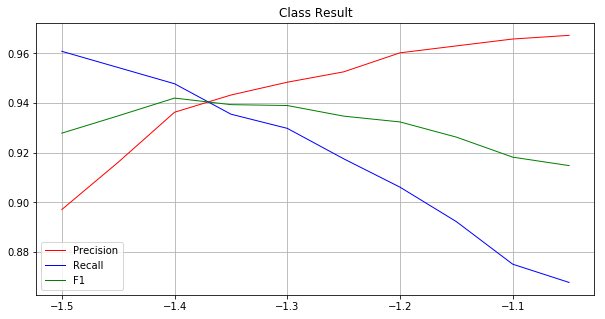

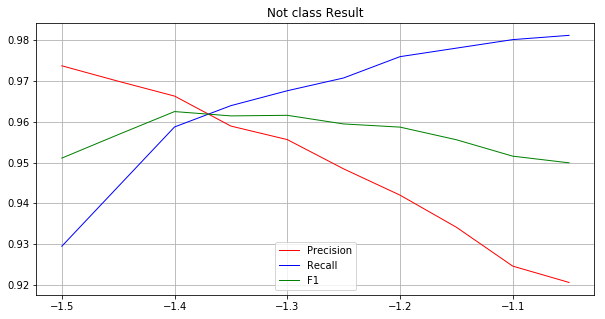

In [457]:
min_th = -1.5
max_th = -1.0
step = 0.05

_, fmin, fmax, logmin, logmax = best_values

classifier = Classifier(fmin=fmin, fmax=fmax, logmin=logmin, logmax=logmax)
classifier.train(train_docs)

avgF1 = plot_results(train_docs, min_threshold=min_th, max_threshold=max_th, 
                     step=step, plot=True)

## Делаем submit

In [458]:
TEST_DATA_FILE  = 'kaggle_test_data_tab.csv.gz'

test_docs = load_csv(TEST_DATA_FILE)

threshold = -1.3

with open('my_submission.csv', 'w', newline='') as fout:
    fout.write('Id,Prediction\n')
    for item in classifier.predict_all(test_docs):
        prediction =  1 if item[3] > threshold else 0
        fout.write('{},{}\n'.format(item[0], prediction))